In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import subprocess
from glob import glob
from pkg import *

In [2]:
datasets = [1, 2, 3]

myPaths = path.PathManager(datasets=datasets)
myProcessor = process.Processor(paths=myPaths, datasets=datasets)
params = myProcessor.get_parameters()
print(params)
# print(f"clen: {params.clen}, photon_energy: {params.photon_energy}")

f.get_counts(paths=myPaths, datasets=datasets)

['01', '02', '03']
Water backgrounds initialized: 3
{'01': {'clen': 0.15, 'photon_energy': 6000}, '02': {'clen': 0.15, 'photon_energy': 7000}, '03': {'clen': 0.15, 'photon_energy': 8000}}
Paths refreshed for dataset ['01', '02', '03'].
Directory: peaks/01
	Total files: 58
	Normal images: 39
	Empty images: 19
Directory: labels/01
	Total files: 97
	Normal images: 78
	Empty images: 19
Directory: peaks_water_overlay/01
	Total files: 97
	Normal images: 78
	Empty images: 19
Directory: peaks/02
	Total files: 17
	Normal images: 17
	Empty images: 0
Directory: labels/02
	Total files: 17
	Normal images: 17
	Empty images: 0
Directory: peaks_water_overlay/02
	Total files: 17
	Normal images: 17
	Empty images: 0
Directory: peaks/03
	Total files: 15
	Normal images: 15
	Empty images: 0
Directory: labels/03
	Total files: 15
	Normal images: 15
	Empty images: 0
Directory: peaks_water_overlay/03
	Total files: 15
	Normal images: 15
	Empty images: 0


In [3]:
f.get_counts(paths=myPaths, datasets=datasets)
# %run process_directory.py ../../images  --percent_empty 0.5 
# f.get_counts(paths=myPaths, datasets=datasets)

Paths refreshed for dataset ['01', '02', '03'].
Directory: peaks/01
	Total files: 58
	Normal images: 39
	Empty images: 19
Directory: labels/01
	Total files: 97
	Normal images: 78
	Empty images: 19
Directory: peaks_water_overlay/01
	Total files: 97
	Normal images: 78
	Empty images: 19
Directory: peaks/02
	Total files: 17
	Normal images: 17
	Empty images: 0
Directory: labels/02
	Total files: 17
	Normal images: 17
	Empty images: 0
Directory: peaks_water_overlay/02
	Total files: 17
	Normal images: 17
	Empty images: 0
Directory: peaks/03
	Total files: 15
	Normal images: 15
	Empty images: 0
Directory: labels/03
	Total files: 15
	Normal images: 15
	Empty images: 0
Directory: peaks_water_overlay/03
	Total files: 15
	Normal images: 15
	Empty images: 0


In [10]:
myDataManager = data.DatasetManager(paths=myPaths, datasets=datasets, transform=None)

# peak, label, overlay are valid types
# clen, photon_energy = myProcessor.get_parameters()

# f.check_attributes(paths=myPaths, dataset=datasets, type='peak', clen=clen, photon_energy=photon_energy) 
# f.check_attributes(paths=myPaths, dataset=datasets, type='overlay', clen=clen, photon_energy=photon_energy)
# f.check_attributes(paths=myPaths, dataset=datasets, type='label', clen=clen, photon_energy=photon_energy)

train_loader, test_loader = f.prepare(data_manager=myDataManager, batch_size=10)

Actual percentage of empty images: 16.379310344827587% across peaks, water_overlays, and labels directories.

Final dataset sizes - Peaks: 90, Labels: 129, Overlays: 129

Data prepared.
Train size: 72
Test size: 18
Batch size: 10
Number of batches in train_loader: 8 



In [5]:
# f.check_attributes(paths=myPaths, dataset=datasets, type='peak', clen=clen, photon_energy=photon_energy)
# test_path = myPaths.get_peak_image_paths(datasets)[0]
# test = f.retrieve_attributes(test_path) 
# print(test)

In [6]:
dir(m)

['BasicCNN1',
 'BasicCNN2',
 'BasicCNN3',
 'DenseNet121_Weights',
 'DenseNetBraggPeakClassifier',
 'F',
 'Multi_Class_CNN1',
 'ResNet50BraggPeakClassifier',
 'ResNet50_Weights',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__spec__',
 'models',
 'nn',
 'np',
 'optim',
 'os',
 'torch']

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")
print(device)

model1 = m.Multi_Class_CNN1().to(device)
# model1 = m.BasicCNN3().to(device)
# criterion = nn.BCEWithLogitsLoss()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model1.parameters(), lr=0.001)

feature = 'clen'
# feature = 'peak'

cfg = {
    'num_epochs': 2,
    'num_classes': 3,
    'batch_size': train_loader.batch_size,
    'test_size': len(train_loader.dataset),
    'test_size': len(test_loader.dataset),
    'criterion': criterion,
    'optimizer': optimizer,
    'device': device,
    'model': model1,
    'threshold': 0.5
    }

labels = {
    'peaks': ["True", "False"],
    "photon_energy": [6000, 7000, 8000],
    "clen": [0.15, 0.25, 0.35]
}

# # arguments: self, model, loader: list, criterion, optimizer, device, cfg: dict
t = train_eval.TrainTestModels(model=model1, loader=[train_loader, test_loader], criterion=criterion, optimizer=optimizer, device=device, cfg=cfg, feature=feature, labels=labels['clen'])

cuda


In [8]:
t.epoch_loop()
t.plot_loss_accuracy()

Model testing and validating: Multi_Class_CNN1
Looking for the feature: clen
-- epoch 0


NameError: name 'attributes' is not defined

labels: [6000, 7000, 8000]
truth: [6000 6000 6000 6000 6000 6000 6000 6000 6000 6000 6000 6000]
prediction: [6000 6000 6000 6000 6000 6000 6000 6000 6000 6000 6000 6000]


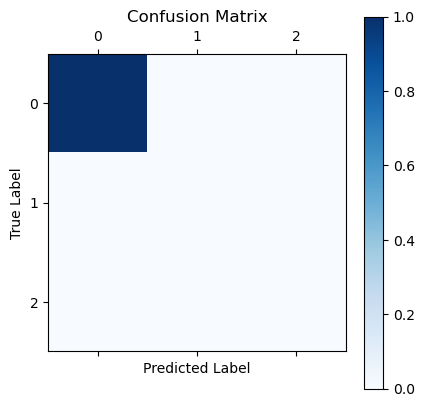

array([[1., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.]])

In [ ]:
t.plot_confusion_matrix()
t.get_confusion_matrix()

In [ ]:
test_peaks = myPaths.get_peak_image_paths(dataset=dataset)[0]
test_water = myPaths.get_peaks_water_overlay_image_paths(dataset=dataset)[0]
test_overlay = myPaths.get_peaks_water_overlay_image_paths(dataset=dataset)[0]
param1, param2 = (0.5, 9000), (0.5, 9000, True)
f.assign_attributes(file_path=test_peaks, params=param1)

Attributes ['params'] assigned to c:\Users\eseveret\Desktop\cxls_hitfinder\images\peaks\01\empty_peak_01_00001.h5


In [ ]:
# t.save_model('../models/cnn3_test.pt')

In [ ]:
# test_model = m.BasicCNN3()
# test_model.load_state_dict(torch.load('../models/cnn3_test.pt'))
# test_model.eval()


In [ ]:
# for data, label, attribute in train_loader:
#     peak, _ = data
#     peak_image_attribute = attribute['peak']
#     output = test_model(peak)
#     print(peak_image_attribute)
#     print(torch.sigmoid(output).reshape(1,-1) > 0.5)
#     print('-------------------')

In [ ]:
"""
How I want the new training input to look.

learning_rate = 0.001
threshold = 0.5
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

optimizer = optim.Adam(model1.parameters(), lr=learning_rate)

cfg = {
    "loader": [train_loader, test_loader]
    'num_epochs': 2,
    'batch_size': train_loader.batch_size,
    'optimizer': optimizer,
    'device': device,
    'threshold': threshold
    }

peak_config = eval.Peak_Detection_Configuration()

t = train_eval.TrainTestModels(cfg, peak_config)
t.epoch_loop()
t.plot_loss_accuracy()
t.plot_confusion_matrix()
t.get_confusion_matrix()
t.save_model('../models/cnn_name.pt')
"""

'\nHow I want the new training input to look.\n\nlearning_rate = 0.001\nthreshold = 0.5\ndevice = torch.device("cuda" if torch.cuda.is_available() else "cpu")\n\noptimizer = optim.Adam(model1.parameters(), lr=learning_rate)\n\ncfg = {\n    "loader": [train_loader, test_loader]\n    \'num_epochs\': 2,\n    \'batch_size\': train_loader.batch_size,\n    \'optimizer\': optimizer,\n    \'device\': device,\n    \'threshold\': threshold\n    }\n\npeak_config = eval.Peak_Detection_Configuration()\n\nt = train_eval.TrainTestModels(cfg, peak_config)\n'

In [ ]:
"""
How I want the pipeline to look.

cnn1_path = '../models/cnn1'
cnn2_path = '../models/cnn2'
cnn3_path = '../models/cnn3'

cnn1 = m.BasicCNN1()
cnn2 = m.BasicCNN2()
cnn3 = m.BasicCNN3()

pipeline = pipe.ModelPipeline(cnn1_path, cnn2_path, cnn3_path, cnn1, cnn2, cnn3)
pipeline.run(image)
pipeline.evaluate_results(image_path)
"""

"\nHow I want the pipeline to look.\n\ncnn1_path = '../models/cnn1'\ncnn2_path = '../models/cnn2'\ncnn3_path = '../models/cnn3'\n\ncnn1 = m.BasicCNN1()\ncnn2 = m.BasicCNN2()\ncnn3 = m.BasicCNN3()\n\npipeline = pipe.ModelPipeline(cnn1_path, cnn2_path, cnn3_path, cnn1, cnn2, cnn3)\npipeline.run(image)\npipeline.evaluate_results(image_path)\n\n"